In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 128 entries, PatientID to NoduleType
dtypes: bool(27), float64(86), int64(11), object(4)
memory usage: 12.8+ MB


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
# nlst_democols['num'].pop('nodule')

In [5]:
nlst_democols['num']['other'].append('Mean_Entropy_Kiran')

In [6]:
nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY'],
  'other': ['NoduleCounts', 'Diameter [mm]', 'Mean_Entropy_Kiran']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   

In [7]:
nlst_preds = utils.prep_nlst_preds(nlst_preds_nodule, scanlevel=False, tijmen=False, sybil=False)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 128 entries, PatientID to NoduleType
dtypes: bool(27), float64(86), int64(11), object(4)
memory usage: 12.8+ MB


In [8]:
# nlst_policy_thresholds = pd.read_csv(f"{NLST_PREDS}/policy-thresholds-{len(nlst_preds)}.csv", index_col=0)
# nlst_policy_thresholds

In [9]:
THRESHOLD = 'Brock'

In [10]:
nlst_preds['WhiteOrBlack'] = nlst_preds['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
nlst_democols['cat']['demo'].append('WhiteOrBlack')

In [11]:
MODEL_TO_COL = {
    "Venkadesh": "DL_cal",
    # "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (w/nodule)": "Thijmen_global_show_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [12]:
# nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > nlst_policy_thresholds.loc['Venkadesh', THRESHOLD]).astype(int).to_numpy()
nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > 0.06).astype(int).to_numpy()
nlst_preds['Kiran_PanCan_diff'] = nlst_preds[MODEL_TO_COL['Venkadesh']] - nlst_preds['PanCan2b']

In [13]:
false_positives = nlst_preds.query("label == 0 and Kiran_pred_label == 1")
false_negatives = nlst_preds.query("label == 1 and Kiran_pred_label == 0")

true_positives = nlst_preds.query("label == 1 and Kiran_pred_label == 1")
true_negatives = nlst_preds.query("label == 0 and Kiran_pred_label == 0")

## Difference between Training Info Splits

In [14]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [15]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [16]:
def cat_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [17]:
def num_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [18]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(20)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
224,lungcanc,LC_stage,NaN,3414.0,100.0000,3.0,2.1127,28.0,2.5294,11414.0,100.0000,97.8873,97.4706,0.0000,-0.4167,-97.8873,-97.4706
207,nodule,SemiSolid,1.0,757.0,22.1734,0.0,0.0000,0.0,0.0000,715.0,6.2642,22.1734,22.1734,15.9092,0.0000,-6.2642,-6.2642
191,nodule,GroundGlassOpacity,1.0,635.0,18.5999,0.0,0.0000,0.0,0.0000,2976.0,26.0732,18.5999,18.5999,-7.4733,0.0000,-26.0732,-26.0732
10,demo,Gender,1.0,2008.0,58.8166,71.0,50.0000,656.0,59.2593,6546.0,57.3506,8.8166,-0.4427,1.4660,-9.2593,-7.3506,1.9087
19,demo,Unfinished_ed,1.0,964.0,28.2367,29.0,20.4225,349.0,31.5266,3069.0,26.8880,7.8142,-3.2899,1.3487,-11.1041,-6.4655,4.6386
6,demo,educat,5.0,736.0,21.5583,23.0,16.1972,281.0,25.3839,2499.0,21.8942,5.3611,-3.8256,-0.3359,-9.1867,-5.6970,3.4897
27,demo,marital,5.0,626.0,18.3363,19.0,13.3803,240.0,21.6802,2072.0,18.1531,4.9560,-3.3439,0.1832,-8.2999,-4.7728,3.5271
75,work,wrkfarm,1.0,454.0,13.2982,12.0,8.4507,109.0,9.8464,1245.0,10.9077,4.8475,3.4518,2.3905,-1.3957,-2.4570,-1.0613
54,smoke,pipe,1.0,765.0,22.4077,25.0,17.6056,272.0,24.5709,2376.0,20.8165,4.8021,-2.1632,1.5912,-6.9653,-3.2109,3.7544
213,other,wrknomask,1.0,945.0,27.6801,33.0,23.2394,273.0,24.6612,2785.0,24.3999,4.4407,3.0189,3.2802,-1.4218,-1.1605,0.2613


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
216,lungcanc,LC_stage,110.0,0.0,0.0000,91.0,64.0845,534.0,48.2385,0.0,0.0000,-64.0845,-48.2385,0.0000,15.8460,64.0845,48.2385
234,lungcanc,Adenocarcinoma,1.0,0.0,0.0000,61.0,42.9577,500.0,45.1671,0.0,0.0000,-42.9577,-45.1671,0.0000,-2.2094,42.9577,45.1671
236,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0000,33.0,23.2394,211.0,19.0605,0.0,0.0000,-23.2394,-19.0605,0.0000,4.1789,23.2394,19.0605
197,nodule,NonSolid,1.0,0.0,0.0000,29.0,20.4225,97.0,8.7624,0.0,0.0000,-20.4225,-8.7624,0.0000,11.6601,20.4225,8.7624
203,nodule,PartSolid,1.0,0.0,0.0000,24.0,16.9014,221.0,19.9639,0.0,0.0000,-16.9014,-19.9639,0.0000,-3.0625,16.9014,19.9639
230,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0000,23.0,16.1972,163.0,14.7245,0.0,0.0000,-16.1972,-14.7245,0.0000,1.4727,16.1972,14.7245
209,other,FamilyHistoryLungCa,1.0,874.0,25.6005,52.0,36.6197,327.0,29.5393,2845.0,24.9255,-11.0192,-3.9388,0.6750,7.0804,11.6942,4.6138
193,nodule,NoduleInUpperLung,1.0,1814.0,53.1342,90.0,63.3803,676.0,61.0659,4166.0,36.4990,-10.2461,-7.9317,16.6352,2.3144,26.8813,24.5669
238,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0000,14.0,9.8592,110.0,9.9368,0.0,0.0000,-9.8592,-9.9368,0.0000,-0.0776,9.8592,9.9368
222,lungcanc,LC_stage,400.0,0.0,0.0000,13.0,9.1549,163.0,14.7245,0.0,0.0000,-9.1549,-14.7245,0.0000,-5.5696,9.1549,14.7245


In [19]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(20)

,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
20,nodule,CoordY,50%,0.3350,-17.8450,1.3408,-52.5700,18.1800,-1.0058,52.9050,-19.1858,34.7250,53.9108
21,nodule,CoordY,mean,-23.8909,-29.6896,-23.1025,-50.6893,5.7987,-0.7884,26.7984,-6.5871,20.9997,27.5868
25,other,Diameter [mm],mean,11.1547,8.3972,15.1142,6.3864,2.7575,-3.9595,4.7683,-6.7170,2.0108,8.7278
24,other,Diameter [mm],50%,9.6000,7.4500,12.8000,5.5000,2.1500,-3.2000,4.1000,-5.3500,1.9500,7.3000
7,demo,weight,mean,179.4982,177.9155,175.4596,184.0172,1.5827,4.0386,-4.5190,2.4559,-6.1017,-8.5576
6,demo,weight,50%,177.0000,175.5000,173.0000,180.0000,1.5000,4.0000,-3.0000,2.5000,-4.5000,-7.0000
5,demo,height,mean,68.0690,67.3944,67.8397,67.9519,0.6746,0.2293,0.1171,-0.4453,-0.5575,-0.1122
23,other,NoduleCounts,mean,2.4241,2.1620,2.4119,2.6129,0.2621,0.0122,-0.1888,-0.2499,-0.4509,-0.2010
11,smoke,smokeday,mean,28.6593,28.5634,30.0750,28.4119,0.0959,-1.4157,0.2474,-1.5116,0.1515,1.6631
27,other,Mean_Entropy_Kiran,mean,0.3201,0.2987,0.2939,0.2647,0.0214,0.0262,0.0554,0.0048,0.0340,0.0292


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
19,nodule,CoordZ,mean,39.2967,63.7262,66.6946,-14.3776,-24.4295,-27.3979,53.6743,-2.9684,78.1038,81.0722
18,nodule,CoordZ,50%,-126.4200,-106.8800,-112.5100,-157.0500,-19.5400,-13.9100,30.6300,5.6300,50.1700,44.5400
16,nodule,CoordX,50%,-36.4850,-24.0404,-37.7200,-46.4200,-12.4446,1.2350,9.9350,13.6796,22.3796,8.7000
14,smoke,pkyr,50%,51.2500,54.0000,57.0000,50.0000,-2.7500,-5.7500,1.2500,-3.0000,4.0000,7.0000
17,nodule,CoordX,mean,-10.1376,-7.4994,-10.6165,-14.6133,-2.6382,0.4789,4.4757,3.1171,7.1139,3.9968
15,smoke,pkyr,mean,58.8407,60.9975,64.9514,57.1976,-2.1568,-6.1107,1.6431,-3.9539,3.7999,7.7538
12,smoke,smokeyr,50%,41.0000,43.0000,44.0000,41.0000,-2.0000,-3.0000,0.0000,-1.0000,2.0000,3.0000
13,smoke,smokeyr,mean,41.5146,43.0986,43.7100,40.7351,-1.5840,-2.1954,0.7795,-0.6114,2.3635,2.9749
8,smoke,smokeage,50%,16.0000,17.0000,16.0000,16.0000,-1.0000,0.0000,0.0000,1.0000,1.0000,0.0000
0,demo,BMI,50%,26.5784,27.1279,26.1672,27.2592,-0.5495,0.4112,-0.6808,0.9607,-0.1313,-1.0920


### Now with the top 100 scores that were different from PanCan

In [20]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
}

In [21]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(20)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
172,lungcanc,LC_stage,NaN,100.0,100.0,1.0,1.0,99.0
156,nodule,SemiSolid,1.0,16.0,16.0,0.0,0.0,16.0
105,disease,diagchro,1.0,19.0,19.0,7.0,7.0,12.0
83,disease,diagemph,1.0,22.0,22.0,12.0,12.0,10.0
162,other,wrknomask,1.0,34.0,34.0,24.0,24.0,10.0
10,demo,Gender,1.0,61.0,61.0,52.0,52.0,9.0
142,nodule,GroundGlassOpacity,1.0,7.0,7.0,0.0,0.0,7.0
19,demo,Unfinished_ed,1.0,28.0,28.0,21.0,21.0,7.0
55,work,wrkasbe,1.0,11.0,11.0,5.0,5.0,6.0
5,demo,educat,4.0,20.0,20.0,15.0,15.0,5.0


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
165,lungcanc,LC_stage,110.0,0.0,0.0,63.0,63.0,-63.0
181,lungcanc,Adenocarcinoma,1.0,0.0,0.0,49.0,49.0,-49.0
183,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0,23.0,23.0,-23.0
148,nodule,NonSolid,1.0,0.0,0.0,17.0,17.0,-17.0
43,smoke,cigsmok,1.0,50.0,50.0,64.0,64.0,-14.0
178,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0,13.0,13.0,-13.0
144,nodule,NoduleInUpperLung,1.0,47.0,47.0,60.0,60.0,-13.0
158,other,FamilyHistoryLungCa,1.0,21.0,21.0,32.0,32.0,-11.0
152,nodule,PartSolid,1.0,0.0,0.0,9.0,9.0,-9.0
11,demo,Gender,2.0,39.0,39.0,48.0,48.0,-9.0


In [22]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(20)

,category,attribute,value,FP,FN,diff_FP_FN
19,nodule,CoordZ,mean,231.4671,82.7563,148.7108
20,nodule,CoordY,50%,15.1200,-19.4924,34.6124
21,nodule,CoordY,mean,-11.5051,-33.9758,22.4707
18,nodule,CoordZ,50%,-102.9100,-107.6450,4.7350
25,other,Diameter [mm],mean,11.2490,6.7890,4.4600
24,other,Diameter [mm],50%,10.2000,6.5000,3.7000
7,demo,weight,mean,179.8600,178.4300,1.4300
2,demo,Age,50%,64.0000,63.0000,1.0000
6,demo,weight,50%,180.0000,179.0000,1.0000
23,other,NoduleCounts,mean,2.6000,2.0500,0.5500


,category,attribute,value,FP,FN,diff_FP_FN
16,nodule,CoordX,50%,-41.7900,-21.8150,-19.9750
10,smoke,smokeday,50%,20.0000,30.0000,-10.0000
14,smoke,pkyr,50%,47.0000,55.7500,-8.7500
17,nodule,CoordX,mean,-11.2890,-3.1082,-8.1808
15,smoke,pkyr,mean,56.7375,62.1700,-5.4325
12,smoke,smokeyr,50%,41.0000,43.0000,-2.0000
13,smoke,smokeyr,mean,41.4000,43.3400,-1.9400
11,smoke,smokeday,mean,27.4100,28.8900,-1.4800
0,demo,BMI,50%,26.2295,27.1279,-0.8984
9,smoke,smokeage,mean,16.2400,16.6500,-0.4100


## False Positives

In [23]:
false_positives = nlst_preds.query("label == 0 and Kiran_pred_label == 1")
false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
4936,1.2.840.113654.2.55.98861299711525430877993378...,0,1,0.027097,0.870740,0.843643
12235,1.3.6.1.4.1.14519.5.2.1.7009.9004.337737422324...,0,1,0.032591,0.821022,0.788431
12534,1.3.6.1.4.1.14519.5.2.1.7009.9004.317792465838...,0,1,0.030209,0.794943,0.764734
10987,1.3.6.1.4.1.14519.5.2.1.7009.9004.305261900952...,0,1,0.133418,0.830687,0.697270
15527,1.3.6.1.4.1.14519.5.2.1.7009.9004.101975354069...,0,1,0.111572,0.795541,0.683969
...,...,...,...,...,...,...
9682,1.2.840.113654.2.55.12214417867856293761715489...,0,1,0.641022,0.152304,-0.488718
5908,1.2.840.113654.2.55.40114302739641107006168416...,0,1,0.597842,0.069518,-0.528324
7944,1.2.840.113654.2.55.98591848380988807922321793...,0,1,0.726740,0.177436,-0.549304
11899,1.3.6.1.4.1.14519.5.2.1.7009.9004.147148054836...,0,1,0.693475,0.109388,-0.584087


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

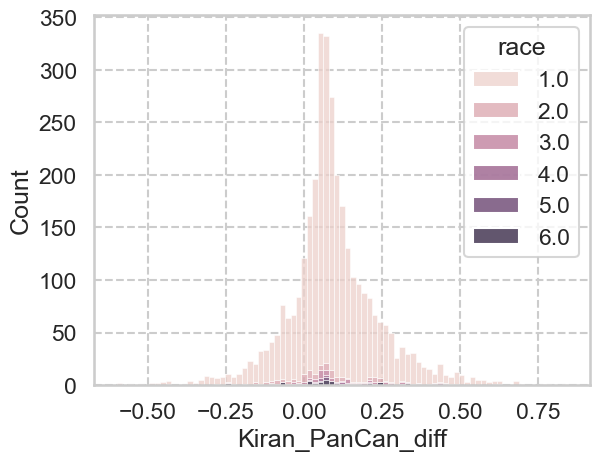

In [24]:
sns.histplot(false_positives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [25]:
race_fps = {
    "white": false_positives.query("race == 1"),
    "black": false_positives.query("race == 2"),
}

In [26]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fps).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(20)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
20,demo,WhiteOrBlack,1.0,3187.0,100.0000,0.0,0.0000,100.0000
31,demo,race,1.0,3187.0,100.0000,0.0,0.0000,100.0000
33,demo,WhiteOrBlack,1.0,3187.0,100.0000,0.0,0.0000,100.0000
17,demo,NonHispanicWhite,True,3137.0,98.4311,0.0,0.0000,98.4311
23,demo,marital,2.0,2151.0,67.4929,36.0,38.7097,28.7832
13,demo,Married,True,2151.0,67.4929,36.0,38.7097,28.7832
47,smoke,pipe,1.0,753.0,23.6272,5.0,5.3763,18.2509
63,work,wrkfarm,1.0,432.0,13.5551,0.0,0.0000,13.5551
4,demo,educat,3.0,861.0,27.0160,14.0,15.0538,11.9622
36,smoke,smokelive,1.0,2806.0,88.0452,72.0,77.4194,10.6258


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
32,demo,race,2.0,0.0,0.0000,93.0,100.0000,-100.0000
34,demo,WhiteOrBlack,2.0,0.0,0.0000,93.0,100.0000,-100.0000
21,demo,WhiteOrBlack,2.0,0.0,0.0000,93.0,100.0000,-100.0000
19,demo,Unfinished_ed,True,884.0,27.7377,52.0,55.9140,-28.1763
42,smoke,cigsmok,1,1566.0,49.1371,66.0,70.9677,-21.8306
120,disease,diaghype,1.0,1107.0,34.7349,51.0,54.8387,-20.1038
3,demo,educat,2.0,202.0,6.3382,21.0,22.5806,-16.2424
24,demo,marital,3.0,290.0,9.0995,22.0,23.6559,-14.5564
56,work,wrkasbe,1.0,158.0,4.9576,17.0,18.2796,-13.3220
6,demo,educat,5.0,682.0,21.3994,31.0,33.3333,-11.9339


In [27]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fps)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(20)

,category,attribute,value,white,black,diff_white_black
19,nodule,CoordZ,mean,13.9826,-72.5262,86.5088
20,nodule,CoordY,50%,0.1400,-72.8500,72.9900
21,nodule,CoordY,mean,-23.8820,-61.3813,37.4993
14,smoke,pkyr,50%,52.0000,45.0000,7.0000
18,nodule,CoordZ,50%,-128.4300,-135.2700,6.8400
15,smoke,pkyr,mean,59.0245,52.8817,6.1428
16,nodule,CoordX,50%,-36.5600,-41.7200,5.1600
10,smoke,smokeday,50%,25.0000,20.0000,5.0000
11,smoke,smokeday,mean,28.7311,23.9785,4.7526
8,smoke,smokeage,50%,16.0000,15.0000,1.0000


,category,attribute,value,white,black,diff_white_black
6,demo,weight,50%,177.0000,180.0000,-3.0000
12,smoke,smokeyr,50%,41.0000,44.0000,-3.0000
13,smoke,smokeyr,mean,41.5171,43.8710,-2.3539
24,other,Diameter [mm],50%,9.6000,11.4000,-1.8000
25,other,Diameter [mm],mean,11.1333,12.0419,-0.9086
5,demo,height,mean,68.1033,68.4348,-0.3315
2,demo,Age,50%,63.0000,63.0000,0.0000
4,demo,height,50%,68.0000,68.0000,0.0000
22,other,NoduleCounts,50%,2.0000,2.0000,0.0000
27,other,Mean_Entropy_Kiran,mean,0.3213,0.3066,0.0147


## False Negatives

In [28]:
false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=True)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
15557,1.3.6.1.4.1.14519.5.2.1.7009.9004.143586271866...,1,0,0.525368,0.051651,-0.473717
15555,1.3.6.1.4.1.14519.5.2.1.7009.9004.175985546338...,1,0,0.481470,0.015758,-0.465713
15556,1.3.6.1.4.1.14519.5.2.1.7009.9004.276011104552...,1,0,0.450988,0.040701,-0.410287
10954,1.3.6.1.4.1.14519.5.2.1.7009.9004.132150608450...,1,0,0.435912,0.050518,-0.385394
9826,1.2.840.113654.2.55.12881149774656140035795514...,1,0,0.403346,0.021186,-0.382160
...,...,...,...,...,...,...
9276,1.2.840.113654.2.55.15505637602509032624908092...,1,0,0.009398,0.052898,0.043500
4316,1.2.840.113654.2.55.43097405894809947626255571...,1,0,0.014876,0.058605,0.043729
6666,1.2.840.113654.2.55.52319464844254142957182638...,1,0,0.005617,0.050282,0.044665
5243,1.2.840.113654.2.55.21791708195072249329063941...,1,0,0.003991,0.048763,0.044772


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

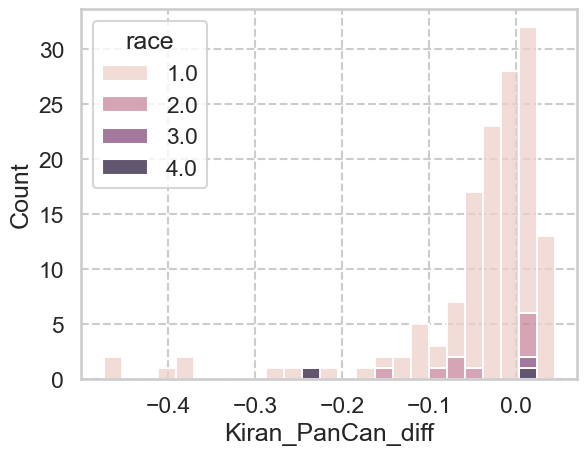

In [29]:
sns.histplot(false_negatives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [30]:
race_fns = {
    "white": false_negatives.query("race == 1"),
    "black": false_negatives.query("race == 2"),
}

In [31]:
for m in race_fns:
    print(m, len(race_fns[m]))

white 130
black 9


In [32]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fns).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(30)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
19,demo,WhiteOrBlack,1.0,130.0,100.0000,0.0,0.0000,100.0000
16,demo,NonHispanicWhite,1.0,130.0,100.0000,0.0,0.0000,100.0000
29,demo,WhiteOrBlack,1.0,130.0,100.0000,0.0,0.0000,100.0000
27,demo,race,1.0,130.0,100.0000,0.0,0.0000,100.0000
161,lungcanc,Squamous_cell_carcinoma,1.0,32.0,24.6154,0.0,0.0000,24.6154
35,smoke,cigar,1.0,28.0,21.5385,0.0,0.0000,21.5385
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
14,demo,HighSchoolPlus,1.0,127.0,97.6923,7.0,77.7778,19.9145
42,smoke,pipe,1.0,25.0,19.2308,0.0,0.0000,19.2308
9,demo,Gender,1.0,67.0,51.5385,3.0,33.3333,18.2052


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
20,demo,WhiteOrBlack,2.0,0.0,0.0000,9.0,100.0000,-100.0000
28,demo,race,2.0,0.0,0.0000,9.0,100.0000,-100.0000
30,demo,WhiteOrBlack,2.0,0.0,0.0000,9.0,100.0000,-100.0000
37,smoke,cigsmok,1.0,71.0,54.6154,9.0,100.0000,-45.3846
96,disease,diaghype,1.0,50.0,38.4615,7.0,77.7778,-39.3163
139,other,wrknomask,1.0,28.0,21.5385,4.0,44.4444,-22.9059
87,disease,diagdiab,1.0,16.0,12.3077,3.0,33.3333,-21.0256
65,work,wrkbutc,1.0,2.0,1.5385,2.0,22.2222,-20.6837
44,work,wrkbaki,1.0,2.0,1.5385,2.0,22.2222,-20.6837
2,demo,educat,1.0,3.0,2.3077,2.0,22.2222,-19.9145


In [33]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('category == "nodule"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('category == "nodule"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
130,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812
128,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
125,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
122,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
132,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
132,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282
122,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
125,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
128,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
130,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812


In [34]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('attribute == "LC_stage"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('attribute == "LC_stage"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
146,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
144,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
149,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
147,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
143,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
148,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
145,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
145,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453
148,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
143,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
147,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
149,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
144,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
146,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710


In [35]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fns)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(20)

,category,attribute,value,white,black,diff_white_black
19,nodule,CoordZ,mean,46.8267,-104.5144,151.3411
17,nodule,CoordX,mean,-2.0466,-70.9500,68.9034
16,nodule,CoordX,50%,-15.4550,-65.1900,49.7350
20,nodule,CoordY,50%,-16.9300,-44.2000,27.2700
15,smoke,pkyr,mean,62.6050,41.1111,21.4939
14,smoke,pkyr,50%,55.5000,40.0000,15.5000
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
11,smoke,smokeday,mean,29.3154,20.0000,9.3154
21,nodule,CoordY,mean,-28.6884,-37.2100,8.5216
4,demo,height,50%,68.0000,64.0000,4.0000


,category,attribute,value,white,black,diff_white_black
7,demo,weight,mean,178.4923,188.4444,-9.9521
1,demo,BMI,mean,27.3050,33.1619,-5.8569
0,demo,BMI,50%,27.1279,32.5531,-5.4252
18,nodule,CoordZ,50%,-111.1600,-106.2400,-4.9200
8,smoke,smokeage,50%,16.0000,20.0000,-4.0000
9,smoke,smokeage,mean,16.5308,19.3333,-2.8025
6,demo,weight,50%,175.5000,178.0000,-2.5000
2,demo,Age,50%,63.0000,65.0000,-2.0000
24,other,Diameter [mm],50%,7.4500,8.7000,-1.2500
25,other,Diameter [mm],mean,8.3531,9.2444,-0.8913


<Axes: xlabel='pkyr', ylabel='Probability'>

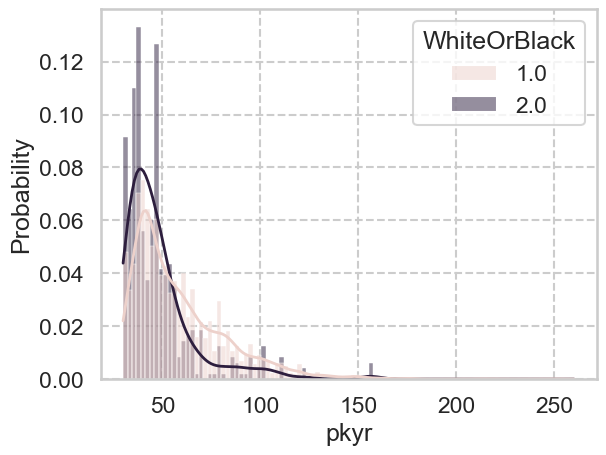

In [43]:
sns.histplot(data=nlst_preds, x='pkyr', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')

,count,mean,std,min,25%,50%,75%,max
NoduleType,,,,,,,,
Calcified,8.0,0.183457,0.173153,0.003378,0.030670,0.185245,0.235260,0.504920
GroundGlassOpacity,3611.0,0.285441,0.288091,0.000009,0.023826,0.171712,0.501096,0.999357
Perifissural,929.0,0.261546,0.282065,0.000014,0.019887,0.150118,0.463545,0.991514
SemiSolid,1472.0,0.279564,0.280566,0.000008,0.023073,0.181773,0.493295,0.995672
Solid,8808.0,0.275579,0.284106,0.000008,0.021224,0.163796,0.489360,0.999962


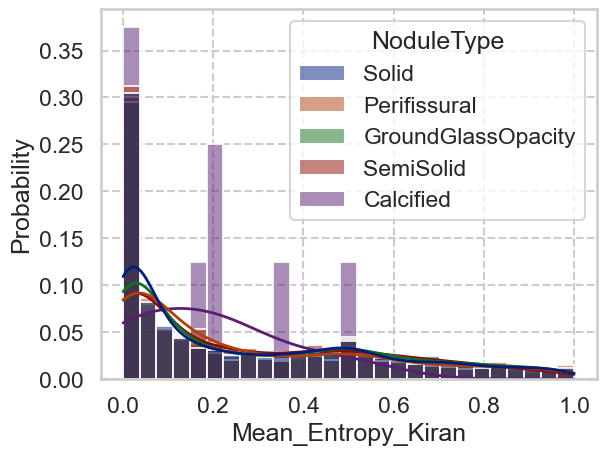

In [47]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='NoduleType', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 0').groupby('NoduleType')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
NoduleType,,,,,,,,
NonSolid,126.0,0.322435,0.293813,0.000214,0.036989,0.270275,0.512828,0.995274
PartSolid,245.0,0.288295,0.275254,0.000034,0.033197,0.194301,0.499774,0.985717
Solid,878.0,0.292170,0.280174,0.000013,0.029327,0.211334,0.498593,0.999881


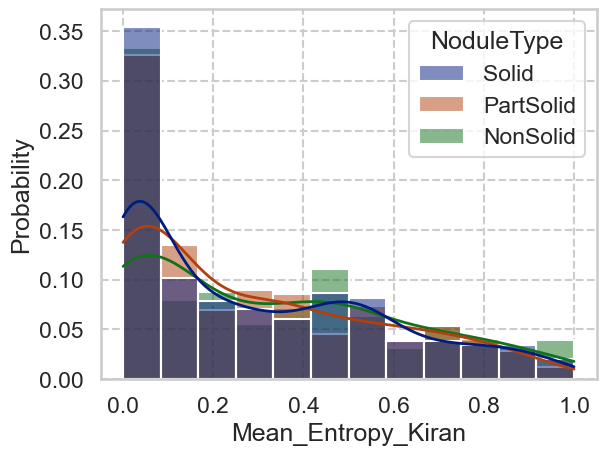

In [48]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='NoduleType', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 1').groupby('NoduleType')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,13895.0,0.276959,0.284546,0.000008,0.022102,0.166052,0.492327,0.999962
2.0,424.0,0.292343,0.287279,0.000029,0.027967,0.183405,0.505826,0.984429


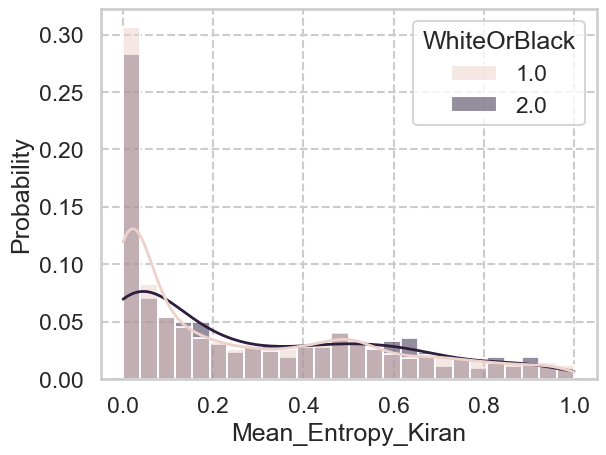

In [49]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 0').groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,1145.0,0.291864,0.281165,0.000013,0.027541,0.206422,0.499353,0.999881
2.0,57.0,0.289561,0.252739,0.000656,0.070353,0.243972,0.453343,0.971731


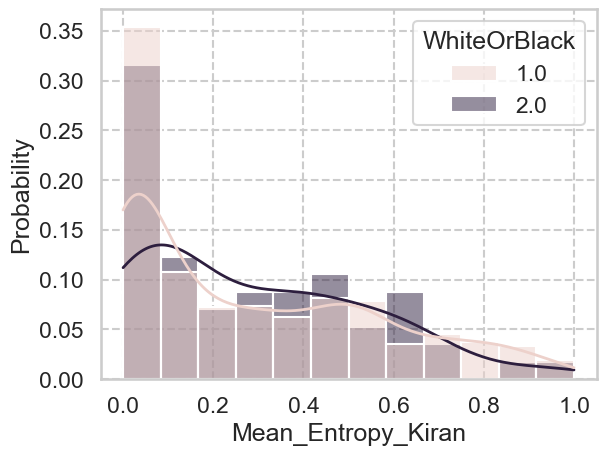

In [50]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 1').groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,130.0,0.308431,0.283746,0.000465,0.030542,0.265886,0.536237,0.947602
2.0,9.0,0.230969,0.230163,0.006565,0.041603,0.095441,0.383061,0.635915


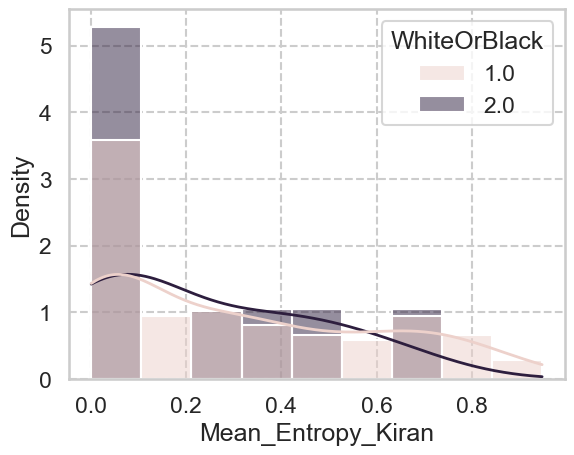

In [38]:
sns.histplot(data=false_negatives, x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='density')
false_negatives.groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,3187.0,0.321319,0.294244,0.000015,0.044414,0.245307,0.544210,0.999886
2.0,93.0,0.306644,0.300267,0.000156,0.016167,0.213393,0.535074,0.984429


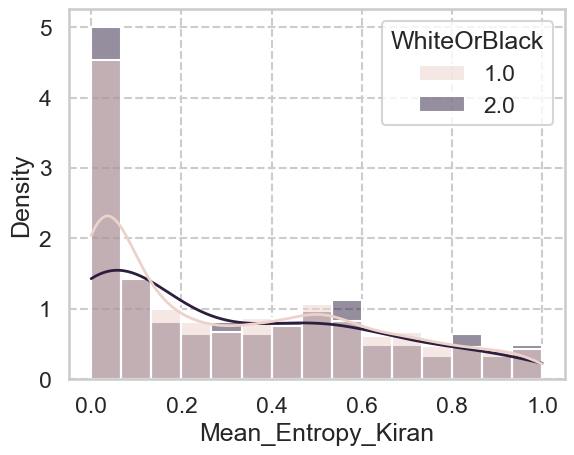

In [39]:
sns.histplot(data=false_positives, x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='density')
false_positives.groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,10489.0,0.278777,0.283793,0.000008,0.022191,0.174570,0.491536,0.999881
1.0,5558.0,0.279183,0.285425,0.000008,0.023778,0.166096,0.496026,0.999962


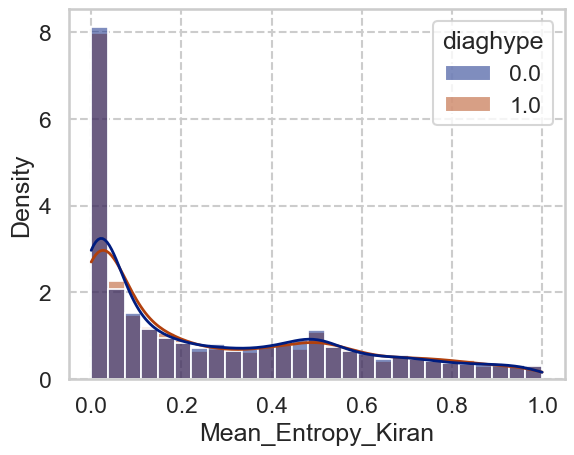

In [51]:
sns.histplot(data=nlst_preds, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,83.0,0.263343,0.269072,0.000465,0.020159,0.194358,0.412891,0.947602
1.0,58.0,0.343731,0.288998,0.002928,0.060096,0.310103,0.634238,0.876993


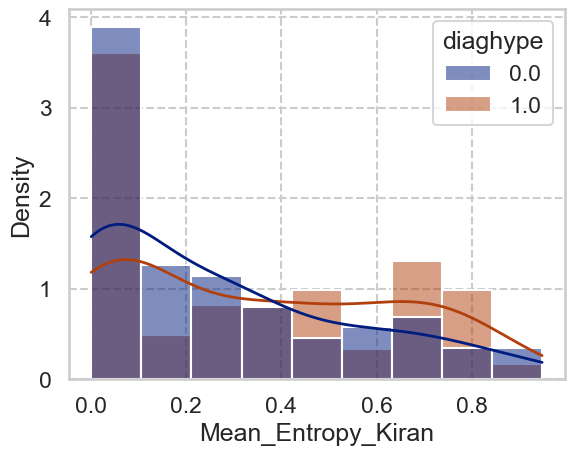

In [52]:
sns.histplot(data=false_negatives, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
false_negatives.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,2197.0,0.322314,0.290886,0.000040,0.048235,0.254548,0.537839,0.995672
1.0,1209.0,0.316887,0.299746,0.000015,0.035952,0.217860,0.547223,0.999886


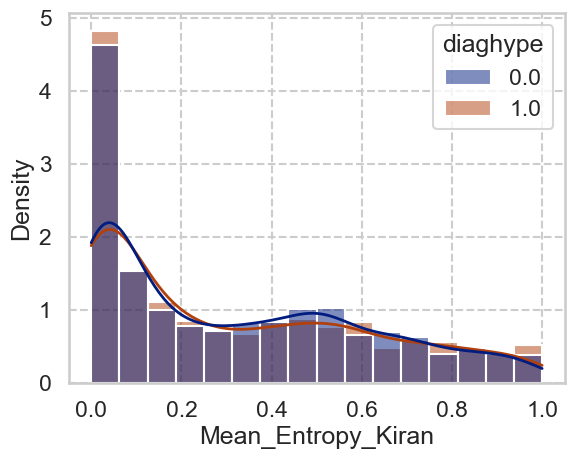

In [53]:
sns.histplot(data=false_positives, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
false_positives.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,798.0,0.285855,0.274361,0.000029,0.026800,0.212564,0.480938,0.999881
1.0,445.0,0.306221,0.290599,0.000013,0.038223,0.201698,0.531774,0.997483


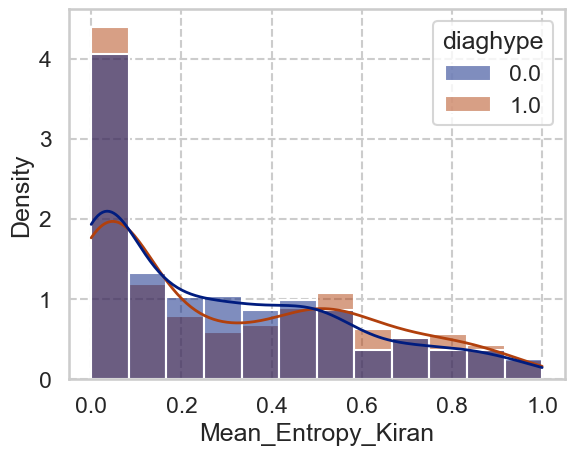

In [55]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.query('label == 1').groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,9691.0,0.278194,0.284561,0.000008,0.022010,0.170154,0.491978,0.999357
1.0,5113.0,0.276830,0.284878,0.000008,0.022556,0.163815,0.493411,0.999962


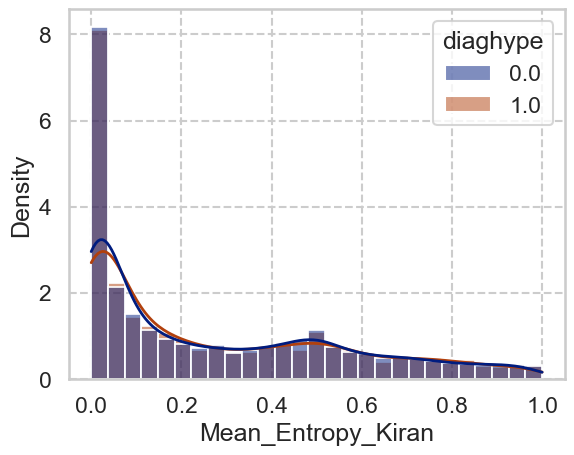

In [56]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.query('label == 0').groupby('diaghype')['Mean_Entropy_Kiran'].describe()